In [1]:
import matplotlib.pyplot as plt
import json
import math

g_list, d_list, ent_list, prob_list, output_tks, output_ids = json.load(open("delta_gamma.json"))

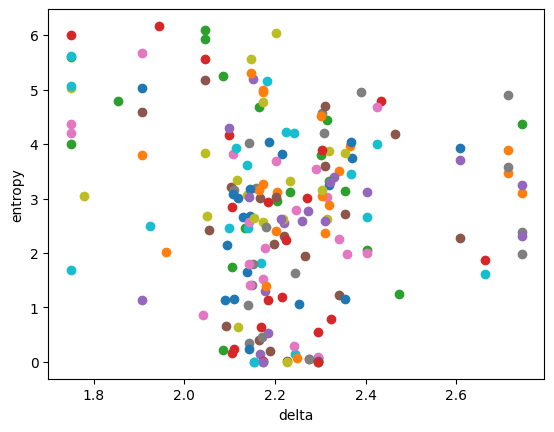

In [2]:
# Check if there is any relationship between entropy (of logits) and delta
# No apparent correlation here

for i in range(200):
	plt.scatter(d_list[i], ent_list[i])
	plt.xlabel("delta")
	plt.ylabel("entropy")
output_tks = [val.lstrip() for val in output_tks]

In [3]:
## Get the percentage of punctuations

import spacy
nlp = spacy.load("en_core_web_sm")
pos_cls = []
pos_tks = []
cnt = 0
for token in output_tks:
    doc = nlp(token)
    flag = 0
    for i in range(len(doc)):
        if doc[i].text == token:
            if doc[i].pos_ == 'PUNCT':
                cnt += 1
            pos_cls.append(doc[i].pos_)
            pos_tks.append(token)
            flag = 1
            if i != 0:
                print(i)
            break
    if flag == 0:
        pos_cls.append('NA')
print(cnt/2000)

0.1035


In [4]:
## Get POS tag for each token, only consider the tokens that has a valid POS tag

pos_cls_all = []
pos_cls = []
pos_tks = []
d_list_pos, g_list_pos = [], []
cnt = 0

for sen in range(10):
	sen_tks = output_tks[200 * sen: 200 * (sen + 1)]
	sen_d_list = d_list[200 * sen: 200 * (sen + 1)]
	sen_g_list = g_list[200 * sen: 200 * (sen + 1)]
	doc = nlp(' '.join(sen_tks))
	for token in doc:
		pos_cls_all.append(token.pos_)
	i = 0
	for j in range(200):
		if doc[i].text == sen_tks[j]:
			pos_cls.append(doc[i].pos_)
			pos_tks.append(sen_tks[j])
			d_list_pos.append(sen_d_list[j])
			g_list_pos.append(sen_g_list[j])
			i += 1
		else:
			for inc in range(6):
				if i + inc < len(doc) and doc[i + inc].text == sen_tks[j]:
					i = i + inc
					pos_cls.append(doc[i].pos_)
					pos_tks.append(sen_tks[j])
					d_list_pos.append(sen_d_list[j])
					g_list_pos.append(sen_g_list[j])
					# cnt += 1
print(len(pos_cls))

1888


In [5]:
## Prepare for plotting

from collections import defaultdict

delta_by_class = defaultdict(list)
for value, cls in zip(d_list_pos, pos_cls):
    delta_by_class[cls].append(value)
gamma_by_class = defaultdict(list)
for value, cls in zip(g_list_pos, pos_cls):
    gamma_by_class[cls].append(value)

## Remove the unfrequent POS tags
for cls in ['CCONJ', 'NUM', 'PART', 'SCONJ', 'X', 'INTJ', 'SYM']:
    del delta_by_class[cls]
    del gamma_by_class[cls]
delta_by_class = dict(sorted(delta_by_class.items(), key=lambda item: -len(item[1])))
gamma_by_class = dict(sorted(gamma_by_class.items(), key=lambda item: -len(item[1])))

keys = delta_by_class.keys()
print(keys)

dict_keys(['NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'PROPN', 'PRON', 'ADJ', 'AUX', 'ADV'])


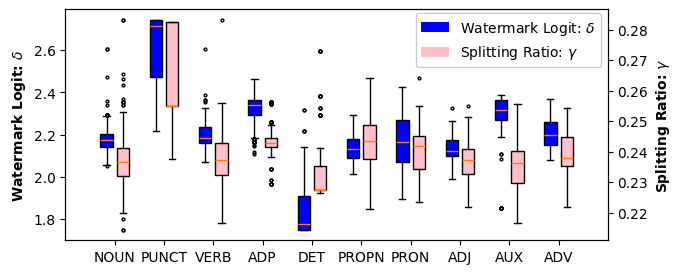

In [6]:
from matplotlib.patches import Patch
import json

positions_delta = [0.2 + inc * 0.6 for inc in range(len(keys))]
positions_gamma = [0.4 + inc * 0.6 for inc in range(len(keys))]
fig, ax1 = plt.subplots(figsize=(7,3))

# Create the boxplot with labels
boxplots = ax1.boxplot(delta_by_class.values(), patch_artist=True, widths=0.15, positions=positions_delta, flierprops={'marker': '.', 'markersize': 4})
colors = ['blue'] * len(keys)
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Watermark Logit: 'r'$\delta$', rotation=90, weight='bold')

ax2 = ax1.twinx()
boxplots = ax2.boxplot(gamma_by_class.values(), patch_artist=True, widths=0.15, positions=positions_gamma, flierprops={'marker': '.', 'markersize': 4})
colors = ['pink'] * len(keys)
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_xticks([0.3 + inc * 0.6 for inc in range(len(keys))])
ax2.set_xticklabels(keys, fontsize=12)
ax2.set_ylabel('Splitting Ratio: '+r'$\gamma$', rotation=90, weight='bold')

legend_elements = [Patch(facecolor='blue', label='Watermark Logit: 'r'$\delta$'),
                   Patch(facecolor='pink', label='Splitting Ratio: ' + r'$\gamma$')]
legend = fig.legend(legend_elements, [h.get_label() for h in legend_elements], loc='upper right', framealpha=1.0, bbox_to_anchor=(0.9, 0.89))# fig.legend(legend_elements, [h.get_label() for h in legend_elements], loc='upper right', bbox_to_anchor=(1.15, 0.89))
legend.set_zorder(100)
# ax2.legend(handles=legend_elements, loc="upper right")
# plt.savefig('delta_gamma.pdf', dpi=600, bbox_inches='tight')
plt.show()


### Transition heatmap from PUNCT, ADJ and DET. 
Based on the following heatmap, we can see ADJ and DET has high rate to follow by a noun, and the previous figure shows the watermark strength is low after ADJ and DET. So our algorithm learns to apply a weak watermark for noun, which boost semantic coherence.

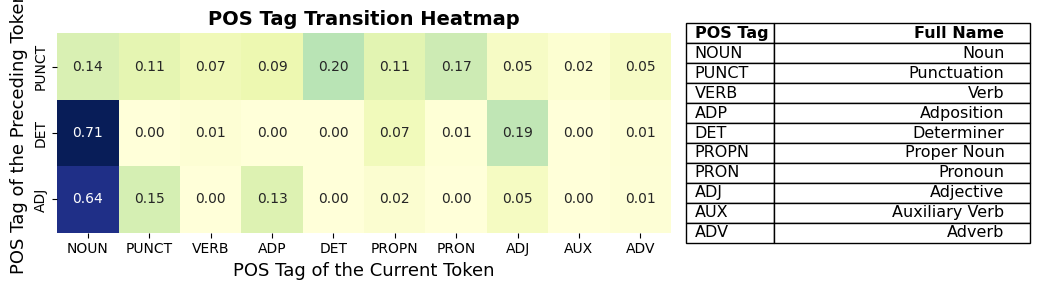

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

unique_classes = keys
class_to_index = {cls: i for i, cls in enumerate(unique_classes)}
num_classes = len(unique_classes)
class_full_names = ['Full Name', 'Noun', 'Punctuation', 'Verb', 'Adposition', 'Determiner', 'Proper Noun', 'Pronoun', 'Adjective', 'Auxiliary Verb', 'Adverb']


# Initialize transition matrix
transition_matrix = np.zeros((num_classes, num_classes))
del_cols = ['CCONJ', 'NUM', 'PART', 'SCONJ', 'X', 'INTJ', 'SYM','SPACE']
# Count transitions using the mapped indices
for i in range(len(pos_cls_all) - 1):
    if (pos_cls_all[i] not in del_cols) and (pos_cls_all[i+1] not in del_cols):
        current_class_index = class_to_index[pos_cls_all[i]]
        next_class_index = class_to_index[pos_cls_all[i + 1]]
        transition_matrix[current_class_index, next_class_index] += 1

# Calculate probabilities
transition_probabilities = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
new_tran_matrix = [transition_probabilities[i] for i in [1,4,7]]
# print(transition_probabilities)
# Plot heatmap
fig, (ax_heatmap, ax_legend) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 2.5]}, figsize=(10.5, 3))
# plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(new_tran_matrix, ax=ax_heatmap, cbar=False, annot=True, cmap='YlGnBu', fmt=".2f", 
            xticklabels=unique_classes, yticklabels=[list(unique_classes)[i] for i in [1,4,7]])
ax_heatmap.set_title("POS Tag Transition Heatmap", weight='bold', fontsize=14)
ax_heatmap.set_xlabel("POS Tag of the Current Token", fontsize=13)
ax_heatmap.set_ylabel("POS Tag of the Preceding Token", fontsize=13)

cell_text = [[name] for name in class_full_names]
table = ax_legend.table(cellText=cell_text, rowLabels=["POS Tag"]+list(unique_classes), loc='center')

cell_height = 0.1  # Adjust cell height
table.auto_set_font_size(False)
table.set_fontsize(11.5)
for key, cell in table.get_celld().items():
    cell.set_height(cell_height)
    if key[0] == 0:  # Make the first row bold
        cell.get_text().set_weight('bold')
ax_legend.axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()
